In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr
import seg_metrics.seg_metrics as sg
import pickle
import matplotlib.patches as mpatches
from skimage import exposure
from scipy import ndimage

In [2]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy version: 1.26.2
Matplotlib version: 3.8.2
SITK version: 2.3.1
Scikit-image version: 0.22.0


/home/daryl/miniconda3/envs/py310/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
patient_id = 9

In [4]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)
PREPROCESSED_STACK_DIR = '{}/stack'.format(PREPROCESSED_BASE_DIR)

### load the MHA

In [5]:
image_exhale_nomask = sitk.GetArrayFromImage(sitk.ReadImage('{}/phase-exhale-nomask.mha'.format(PREPROCESSED_MHA_DIR)))
image_inhale_nomask = sitk.GetArrayFromImage(sitk.ReadImage('{}/phase-inhale-nomask.mha'.format(PREPROCESSED_MHA_DIR)))

mask_union = sitk.GetArrayFromImage(sitk.ReadImage('{}/mask-union.mha'.format(PREPROCESSED_MHA_DIR))).astype(bool)

deformed = sitk.GetArrayFromImage(sitk.ReadImage('{}/deformed.mha'.format(PREPROCESSED_MHA_DIR)))

jacobian_det = sitk.GetArrayFromImage(sitk.ReadImage('{}/vf_jac.mha'.format(PREPROCESSED_MHA_DIR)))
ventilation = jacobian_det-1.0
ventilation[~mask_union] = np.min(ventilation)

In [6]:
print(image_exhale_nomask.shape, image_inhale_nomask.shape, mask_union.shape, jacobian_det.shape, ventilation.shape)

(153, 512, 512) (153, 512, 512) (153, 512, 512) (153, 512, 512) (153, 512, 512)


In [7]:
prop = np.sum(np.array(jacobian_det[mask_union]) < 0) / len(jacobian_det[mask_union].ravel())
print('proportion of voxels with negative values in Jacobian determinant = {}'.format(round(prop, 2)))

proportion of voxels with negative values in Jacobian determinant = 0.02


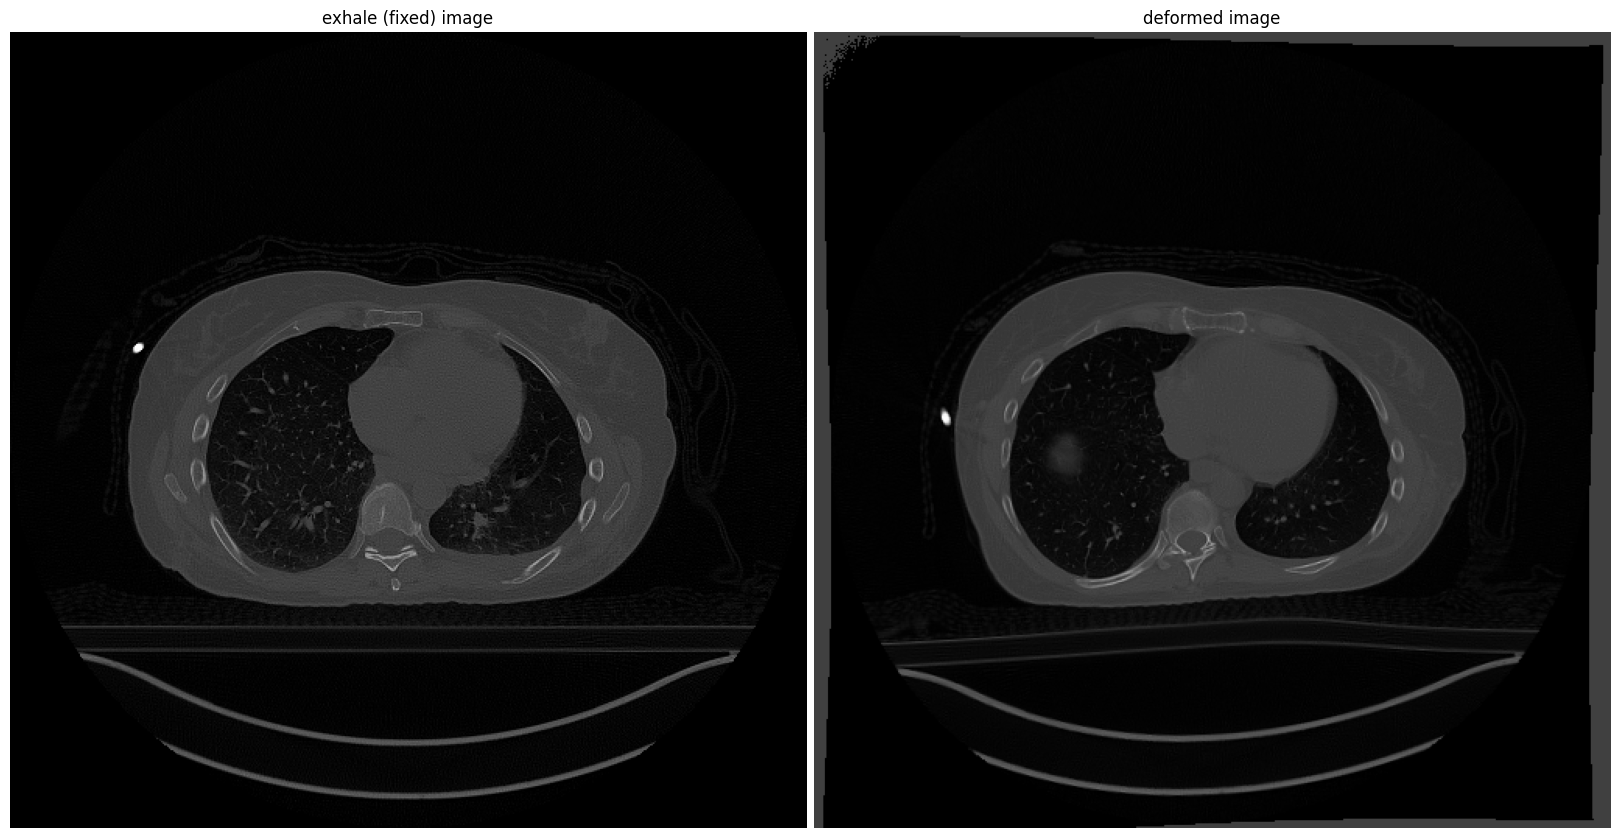

In [8]:
DISPLAY_IDX = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_exhale_nomask[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale (fixed) image')
ax1.set_axis_off()

ax2.imshow(deformed[DISPLAY_IDX], cmap="gray")
ax2.set_title('deformed image')
ax2.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

#### compare with example from Jeremy

In [33]:
EXAMPLE_DIR = '/home/daryl/plastimatch ventilation/example from jeremy'

In [34]:
phase_01 = sitk.GetArrayFromImage(sitk.ReadImage('{}/DIRInput_Bin01.mha'.format(EXAMPLE_DIR)))
phase_02 = sitk.GetArrayFromImage(sitk.ReadImage('{}/DIRInput_Bin02.mha'.format(EXAMPLE_DIR)))
mask = sitk.GetArrayFromImage(sitk.ReadImage('{}/UnionMask.mha'.format(EXAMPLE_DIR))).astype(bool)

deformed = sitk.GetArrayFromImage(sitk.ReadImage('{}/Deformed0102.mha'.format(EXAMPLE_DIR)))

jacobian_det = sitk.GetArrayFromImage(sitk.ReadImage('{}/Jdet0201.mha'.format(EXAMPLE_DIR)))
ventilation = jacobian_det-1.0
ventilation[~mask_exhale] = np.min(ventilation)

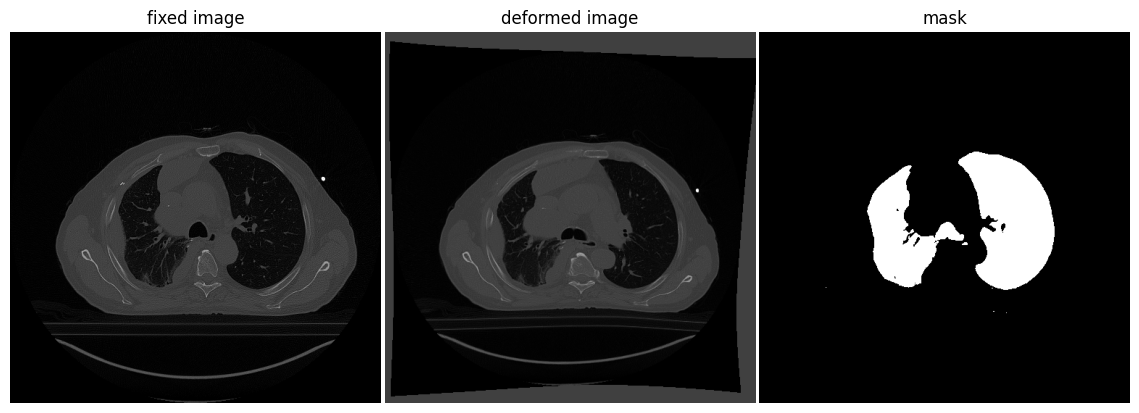

In [35]:
DISPLAY_IDX = 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6))
ax1.imshow(phase_01[DISPLAY_IDX], cmap="gray")
ax1.set_title('fixed image')
ax1.set_axis_off()

ax2.imshow(deformed[DISPLAY_IDX], cmap="gray")
ax2.set_title('deformed image')
ax2.set_axis_off()

ax3.imshow(mask[DISPLAY_IDX], cmap="gray")
ax3.set_title('mask')
ax3.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)